In [1]:
import pandas as pd
import numpy as np
import time
import datetime

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

from matplotlib import pyplot as plt
from scipy.sparse import csr_matrix
import scipy as sp
import re
import gensim
import logging
import seaborn as sns
import sklearn as sk
#logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
%matplotlib inline
#import xgboost

train = pd.read_csv("../data/features/features.csv",
                    header=0,delimiter=",",quotechar='"',error_bad_lines=False)

print("unfiltered data, num samples: %i with num features: %i" %(train.shape[0],train.shape[1]))

train.fillna(' ',inplace=True)
train.dropna(inplace=True)
print("filtered data with samples: %i" %(train.shape[0]))
print(train.columns)

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/timomoeller/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


/home/timomoeller/.virtualenvs/keras/lib/python3.5/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


unfiltered data, num samples: 45885 with num features: 22
filtered data with samples: 45885


In [41]:
# do publishers have slightly different spelling??
# looking at string distance of publishers. result: pretty sure unique journals, no spelling diffs
# small string distances, but only for abbreviated pubs eg. AAM journal, APM journal -> they need to be different
uniPubs = np.unique(pubs)
uniPubs = np.array([x for x in uniPubs if len(x) > 5]) # filtering out unkown
print(uniPubs.shape)

import Levenshtein
d = Levenshtein.distance
ldist = np.zeros((uniPubs.shape[0],uniPubs.shape[0]))
for i in range(uniPubs.shape[0]):
    for j in range(i,uniPubs.shape[0]):
        #ldist[i,j] = d(uniPubs[i],uniPubs[j]) # commented out, takes about 40s

#manually check similar pubs. 
current = 7
print(np.sort(ldist[current])[:10])
print(np.argsort(ldist[current])[:10])
print(uniPubs[current] + '  ' + uniPubs[1328])
plt.hist(ldist.flatten(),bins=40,range=[1,400])
plt.show()

In [20]:
#PREPRocessing

#y labels
useful = train["useful"]

#features
abstracts = train['abstract'].values.astype(dtype=str)
title = train['fulltitle'].values.astype(dtype=str)
journal = train['subtitle'].values.astype(dtype=str)
search = train['searchquery_terms'].values.astype(dtype=str)
num = train['num']

# #only rows with abstract
# idxthere = np.nonzero(train['abstract'] != ' ')[0]
# print("exluding %i rows because of empty abstract" %idxthere.shape[0])
# title = title[idxthere]
# journal = journal[idxthere]
# abstracts = abstracts[idxthere]
# useful = useful[idxthere]

#one hot encoded journals !!! DOESN'T improve performance
from sklearn.feature_extraction.text import CountVectorizer
vect = CountVectorizer(vocabulary=np.unique(journal),binary=True)
hot_journal = vect.fit_transform(journal)
#only keep journals with more than 100 occurences
journal_count = np.sum(hot_journal, axis=0)
idx_imp_journals = np.nonzero(journal_count > 20)[0]
imp_journals = hot_journal[:,idx_imp_journals]

#bag of words for abstracts and titles
reRemoved = [re.sub(r'[^a-z ]', '', s.lower()) for s in abstracts]
vectText = CountVectorizer(max_df=0.6,min_df=10,stop_words=stopwords.words("english"))
bow_text = vectText.fit_transform(reRemoved)

vect = CountVectorizer(max_df=0.6,min_df=4,stop_words=stopwords.words("english"))
reRemoved = [re.sub(r'[^a-z ]', '', s.lower()) for s in title]
bow_title = vect.fit_transform(reRemoved)

reRemoved = [re.sub(r'[^a-z ]', '', s.lower()) for s in search]
bow_search = vect.fit_transform(reRemoved)

#LDA on abstracts bow !!!!! DOESN't improve performance
from sklearn.decomposition import LatentDirichletAllocation
lda = LatentDirichletAllocation(n_topics=50,n_jobs=1)
lda.partial_fit(bow_text)

def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic #%d:" % topic_idx)
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()
topicDist = lda.transform(bow_text)


#combine features Classify for usefulness results
#features = bow_text.tocsr() # AUC: 0.811
#features = sp.sparse.hstack((bow_text, imp_journals)).tocsr() # AUC: 0.811
#features = sp.sparse.hstack((bow_title, bow_text)).tocsr() # AUC: 0.822
#features = sp.sparse.hstack((bow_title, bow_text, imp_journals)).tocsr() # AUC 0.822
features = sp.sparse.hstack((bow_title, bow_text, bow_search)).tocsr() #AUC: 0.842


In [32]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(features, useful, test_size=0.2, random_state=42)
# classification
import xgboost as xgb
model = xgb.XGBClassifier(max_depth=10,n_estimators=400)
model.fit(X_train, y_train)

preds = model.predict_proba(X_test)[:,1]

print(preds.shape)
print("MSE %.3f" %(np.mean(np.power(preds - y_test,2))))
print("AUC: %.3f" %sk.metrics.roc_auc_score(y_test,preds))

(9177,)
MSE 0.162
AUC: 0.842


(9177,)
MSE 0.172
AUC: 0.821


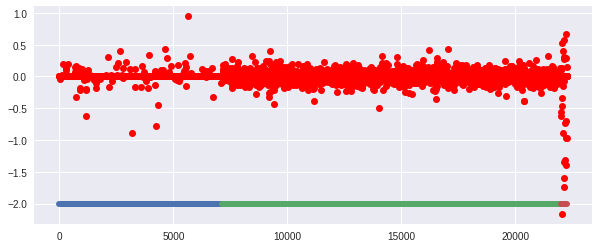

In [63]:
#using a linear model
features = sp.sparse.hstack((bow_title, bow_text, bow_search)).tocsr()
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(features, useful, test_size=0.2, random_state=42)
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(penalty="l1",C=0.1)
clf.fit(X_train,y_train)

preds = clf.predict_proba(X_test)[:,1]

print(preds.shape)
print("MSE %.3f" %(np.mean(np.power(preds - y_test,2))))
print("AUC: %.3f" %sk.metrics.roc_auc_score(y_test,preds))


plt.figure(figsize=(10,4))
plt.plot(clf.coef_.flatten(),'or')
plt.plot([0,bow_title.shape[1]],[-2,-2],label='Title',linewidth=6)
plt.plot([bow_title.shape[1],bow_title.shape[1]+bow_text.shape[1]],[-2.05,-2.05],label='Abstract',linewidth=6)
plt.plot([features.shape[1]-bow_search.shape[1],features.shape[1]],[-2.1,-2.1],label='Query',linewidth=6)

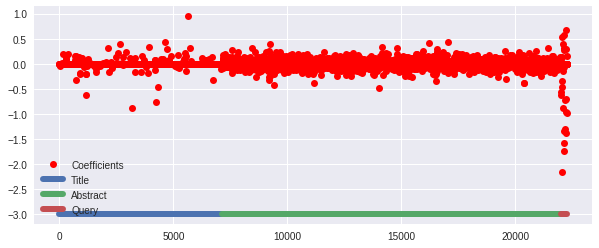

In [71]:
plt.figure(figsize=(10,4))
plt.plot(clf.coef_.flatten(),'or',label="Coefficients")
plt.plot([0,bow_title.shape[1]],[1,-3],label='Title',linewidth=6)
plt.plot([bow_title.shape[1],bow_title.shape[1]+bow_text.shape[1]],[-3,-3],label='Abstract',linewidth=6)
plt.plot([features.shape[1]-bow_search.shape[1],features.shape[1]],[-3,-3],label='Query',linewidth=6)
plt.legend(loc="lower left")
plt.show()

In [18]:
# classification on dataset consisting of true zero and one labels
import xgboost as xgb

true_df = pd.read_csv("../data/features/features-hodenniere.csv",header=0,delimiter=",",quotechar='"',error_bad_lines=False)
true_num = true_df["num"]
msk = np.in1d(num,true_num)

X_train = features[~msk]
X_test = features[msk]
y_train = useful[~msk]
y_test = useful[msk]

model = xgb.XGBClassifier(max_depth=10,n_estimators=400)
model.fit(X_train, y_train)

preds = model.predict_proba(X_test)[:,1]

print("MSE %.3f" %(np.mean(np.power(preds - y_test,2))))
print("AUC: %.3f" %sk.metrics.roc_auc_score(y_test,preds))

MSE 0.189
AUC: 0.796
